In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score

## 1. Data preparation

In [2]:
# load data

X_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test  = pd.read_csv("x_test.csv")

In [3]:
X_train

,session_id,job_ids,actions
0,0,"[305, 299, 300, 290, 282, 274, 264, 261]","['view', 'view', 'view', 'view', 'view', 'view..."
1,1,"[84, 257, 252, 250]","['view', 'view', 'view', 'view']"
2,2,"[241, 237, 221, 309, 310, 306, 301]","['view', 'view', 'apply', 'apply', 'apply', 'a..."
3,3,"[303, 297, 296, 298, 294, 295, 292, 293]","['apply', 'apply', 'apply', 'apply', 'apply', ..."
4,4,"[171, 291, 289, 166, 288, 155]","['apply', 'apply', 'apply', 'apply', 'apply', ..."
...,...,...,...
15877,15877,"[26581, 27314, 27305, 27327, 27138, 27153]","['apply', 'apply', 'apply', 'apply', 'apply', ..."
15878,15878,"[27220, 27219, 27194]","['view', 'view', 'view']"
15879,15879,"[27211, 27210, 27209]","['view', 'view', 'view']"
15880,15880,"[27233, 27220, 27219, 27232, 27231]","['apply', 'view', 'view', 'view', 'view']"


In [4]:
# parse job_ids in list[int]

def parse_list_column(df, col):    
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df

X_train = parse_list_column(X_train, "job_ids")
X_test  = parse_list_column(X_test, "job_ids")

In [5]:
# rebuild complete train sequences (job_ids + target_job)

df = X_train.merge(y_train, on="session_id")

df["full_sequence"] = df["job_ids"] + df["job_id"].apply(lambda x: [x])

In [6]:
df

,session_id,job_ids,actions,job_id,action,full_sequence
0,0,"[305, 299, 300, 290, 282, 274, 264, 261]","['view', 'view', 'view', 'view', 'view', 'view...",84,view,"[305, 299, 300, 290, 282, 274, 264, 261, 84]"
1,1,"[84, 257, 252, 250]","['view', 'view', 'view', 'view']",241,view,"[84, 257, 252, 250, 241]"
2,2,"[241, 237, 221, 309, 310, 306, 301]","['view', 'view', 'apply', 'apply', 'apply', 'a...",303,apply,"[241, 237, 221, 309, 310, 306, 301, 303]"
3,3,"[303, 297, 296, 298, 294, 295, 292, 293]","['apply', 'apply', 'apply', 'apply', 'apply', ...",171,apply,"[303, 297, 296, 298, 294, 295, 292, 293, 171]"
4,4,"[171, 291, 289, 166, 288, 155]","['apply', 'apply', 'apply', 'apply', 'apply', ...",286,apply,"[171, 291, 289, 166, 288, 155, 286]"
...,...,...,...,...,...,...
15877,15877,"[26581, 27314, 27305, 27327, 27138, 27153]","['apply', 'apply', 'apply', 'apply', 'apply', ...",27055,apply,"[26581, 27314, 27305, 27327, 27138, 27153, 27055]"
15878,15878,"[27220, 27219, 27194]","['view', 'view', 'view']",16013,view,"[27220, 27219, 27194, 16013]"
15879,15879,"[27211, 27210, 27209]","['view', 'view', 'view']",27208,view,"[27211, 27210, 27209, 27208]"
15880,15880,"[27233, 27220, 27219, 27232, 27231]","['apply', 'view', 'view', 'view', 'view']",27230,view,"[27233, 27220, 27219, 27232, 27231, 27230]"


## 2. Offline validation setup

In [7]:
# split train / validation by session_id

from sklearn.model_selection import train_test_split

train_sessions, val_sessions = train_test_split(
    df["session_id"].unique(),
    test_size=0.2,
    random_state=42
)

train_df = df[df["session_id"].isin(train_sessions)]
val_df   = df[df["session_id"].isin(val_sessions)]

In [8]:
# implement metrics : Mean Reciprocal Ranking

def compute_mrr(y_true, y_pred, k=10):
    """
    y_true: list of true job_ids
    y_pred: list of list, each inner list = top-k predicted job_ids
    """
    rr = []
    for true_job, preds in zip(y_true, y_pred):
        if true_job in preds[:k]:
            rank = preds.index(true_job) + 1
            rr.append(1 / rank)
        else:
            rr.append(0)
    return sum(rr) / len(rr)


## 3. Baseline job recommender (Markov)

In [9]:
# extract all transitions (job_i to job_i+1)

from collections import defaultdict

transition_counts = defaultdict(int)

for seq in df["full_sequence"]:
    for i in range(len(seq) - 1):
        transition_counts[(seq[i], seq[i+1])] += 1


In [10]:
print(len(transition_counts))
list(transition_counts.items())

104932


[((305, 299), 1),
 ((299, 300), 1),
 ((300, 290), 1),
 ((290, 282), 1),
 ((282, 274), 1),
 ((274, 264), 1),
 ((264, 261), 1),
 ((261, 84), 1),
 ((84, 257), 1),
 ((257, 252), 1),
 ((252, 250), 1),
 ((250, 241), 1),
 ((241, 237), 1),
 ((237, 221), 1),
 ((221, 309), 1),
 ((309, 310), 3),
 ((310, 306), 1),
 ((306, 301), 1),
 ((301, 303), 1),
 ((303, 297), 1),
 ((297, 296), 2),
 ((296, 298), 1),
 ((298, 294), 1),
 ((294, 295), 1),
 ((295, 292), 1),
 ((292, 293), 1),
 ((293, 171), 2),
 ((171, 291), 5),
 ((291, 289), 1),
 ((289, 166), 2),
 ((166, 288), 3),
 ((288, 155), 1),
 ((155, 286), 1),
 ((286, 144), 6),
 ((144, 284), 2),
 ((284, 285), 3),
 ((285, 131), 2),
 ((131, 283), 1),
 ((283, 281), 1),
 ((281, 279), 1),
 ((279, 277), 1),
 ((277, 280), 1),
 ((280, 275), 1),
 ((275, 276), 1),
 ((276, 272), 2),
 ((272, 273), 2),
 ((273, 270), 2),
 ((270, 269), 1),
 ((269, 230), 1),
 ((230, 267), 1),
 ((267, 268), 1),
 ((268, 29), 6),
 ((29, 103), 7),
 ((103, 262), 1),
 ((262, 263), 4),
 ((263, 88), 7

In [11]:
# build job-to-job matrix

trans_df = pd.DataFrame(
    [(i, j, c) for (i, j), c in transition_counts.items()],
    columns=["from_job", "to_job", "count"]
)

In [12]:
print(trans_df.shape)
trans_df["count"].describe()
trans_df.sort_values("count", ascending=False).head()


(104932, 3)


,from_job,to_job,count
1646,621,758,20
9914,89,85,19
7678,1709,2338,19
6886,1460,41,16
1933,319,320,15


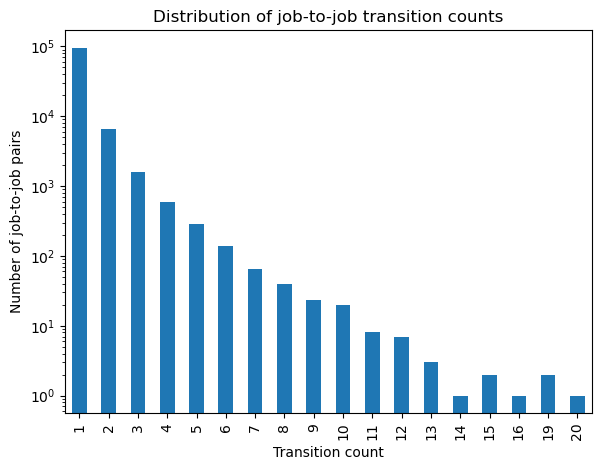

In [13]:
trans_df["count"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Transition count")
plt.ylabel("Number of job-to-job pairs")
plt.title("Distribution of job-to-job transition counts")
plt.tight_layout()
plt.yscale("log")
plt.show()

In [14]:
# normalize in conditional probabilities
# Knowing that the candidate is in job A, what is the probability that they will move to job B?

trans_df["prob"] = (
    trans_df["count"] /
    trans_df.groupby("from_job")["count"].transform("sum")
)

In [15]:
trans_df.head()

,from_job,to_job,count,prob
0,305,299,1,0.058824
1,299,300,1,0.066667
2,300,290,1,0.040000
3,290,282,1,0.100000
4,282,274,1,0.055556


In [16]:
trans_df.groupby("from_job")["prob"].sum().head()


from_job
0    1.0
1    1.0
2    1.0
3    1.0
5    1.0
Name: prob, dtype: float64

In [17]:
# create a fallback in case job_id is not in from_job : overall popularity of jobs

popular_jobs = (
    trans_df.groupby("to_job")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

In [18]:
# implement top 10 from last job
# "If the last job viewed is X, recommend the 10 most likely jobs after X."

def recommend_next_jobs(last_job, trans_df, popular_jobs, k=10):
    candidates = trans_df[trans_df["from_job"] == last_job]
    
    if len(candidates) == 0:
        return popular_jobs[:k]
    
    return (
        candidates
        .sort_values("prob", ascending=False)
        .head(k)["to_job"]
        .tolist()
    )


In [21]:
example_job = trans_df["from_job"].iloc[0]
recommend_next_jobs(example_job, trans_df, popular_jobs)

[299, 2224, 1816, 3091, 4395, 301, 729, 799, 998, 306]

### Evaluate the baseline model

In [22]:
# compute MRR@10 on validation

y_true = []
y_pred = []

for _, row in val_df.iterrows():
    last_job = row["full_sequence"][-2]          # last job seen
    true_job = row["full_sequence"][-1]              # target jon
    
    preds = recommend_next_jobs(
        last_job,
        trans_df,
        popular_jobs,
        k=10
    )
    
    y_true.append(true_job)
    y_pred.append(preds)


In [23]:
# saving baseline score

mrr = compute_mrr(y_true, y_pred, k=10)
print(f"MRR@10 (baseline Markov): {mrr:.4f}")

MRR@10 (baseline Markov): 0.3500


In [24]:
# analysing when true job is missing in top 10

miss_rate = sum(t not in p for t, p in zip(y_true, y_pred)) / len(y_true)
miss_rate

0.31633616619452315

In [25]:
# analysing rank when true job is in top 10

ranks = [p.index(t) + 1 for t, p in zip(y_true, y_pred) if t in p]
sum(ranks)/len(ranks), min(ranks), max(ranks)

(3.5755064456721914, 1, 10)